In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import json
import numpy as np
import matplotlib.pyplot as plt
from Models import AssistantTool
from Models import NASA

### Data preprocessing

##### Projects information


In [18]:
projects = pd.read_csv("Data/Projects.csv", encoding = "latin_1")
projects.drop(columns = ["#","link","link_company","coordinates"], inplace=True)

projects['date'] = pd.to_datetime(projects['date'], format="%d/%m/%Y")
projects["kind"] = projects["kind"].astype("category")
projects["surface_type"] = projects["surface_type"].astype("category")
projects["regime"] = projects["regime"].astype("category")
projects["project_name"] = projects["project_name"].astype("string")

projects.describe()

,latitude,longitude,date,percentage_of_electrical_energy_supplied,power,estimated_power_produced_annually,atmospheric_emission_prevention,used_emission_factor,area
count,30.000000,30.000000,30,10.000000,30.000000,3.000000e+01,3.000000e+01,30.000000,1.800000e+01
mean,6.208974,-74.646901,2018-08-13 23:12:00,67.164043,6780.822333,1.873027e+07,6.905382e+07,0.369867,3.909112e+05
min,2.940861,-76.593333,2017-12-07 00:00:00,20.000000,3.200000,3.655400e+02,1.598400e+03,0.360000,7.000000e+01
25%,4.518986,-75.478319,2018-07-23 00:00:00,34.980320,40.487500,3.812850e+04,1.493450e+04,0.367000,1.212510e+03
50%,4.760862,-74.807250,2018-08-26 12:00:00,75.500000,155.100000,1.426850e+05,7.454300e+04,0.367000,3.508205e+03
75%,8.885021,-74.086389,2018-10-20 00:00:00,100.000000,417.750000,5.421750e+05,2.134172e+05,0.367000,1.476625e+04
max,11.018806,-67.905361,2018-11-25 00:00:00,100.000000,90000.000000,3.380152e+08,2.000000e+09,0.401000,4.371700e+06
std,2.805354,1.559580,NaN,33.775193,22391.500558,6.848216e+07,3.648860e+08,0.011016,1.105009e+06


In [19]:
for property,missing_quantity in projects.isna().sum().items():

    if missing_quantity>0:
        
        section_find = projects[property].interpolate(method="linear")
        section_find = section_find.fillna(section_find.median())
        projects[property] = section_find

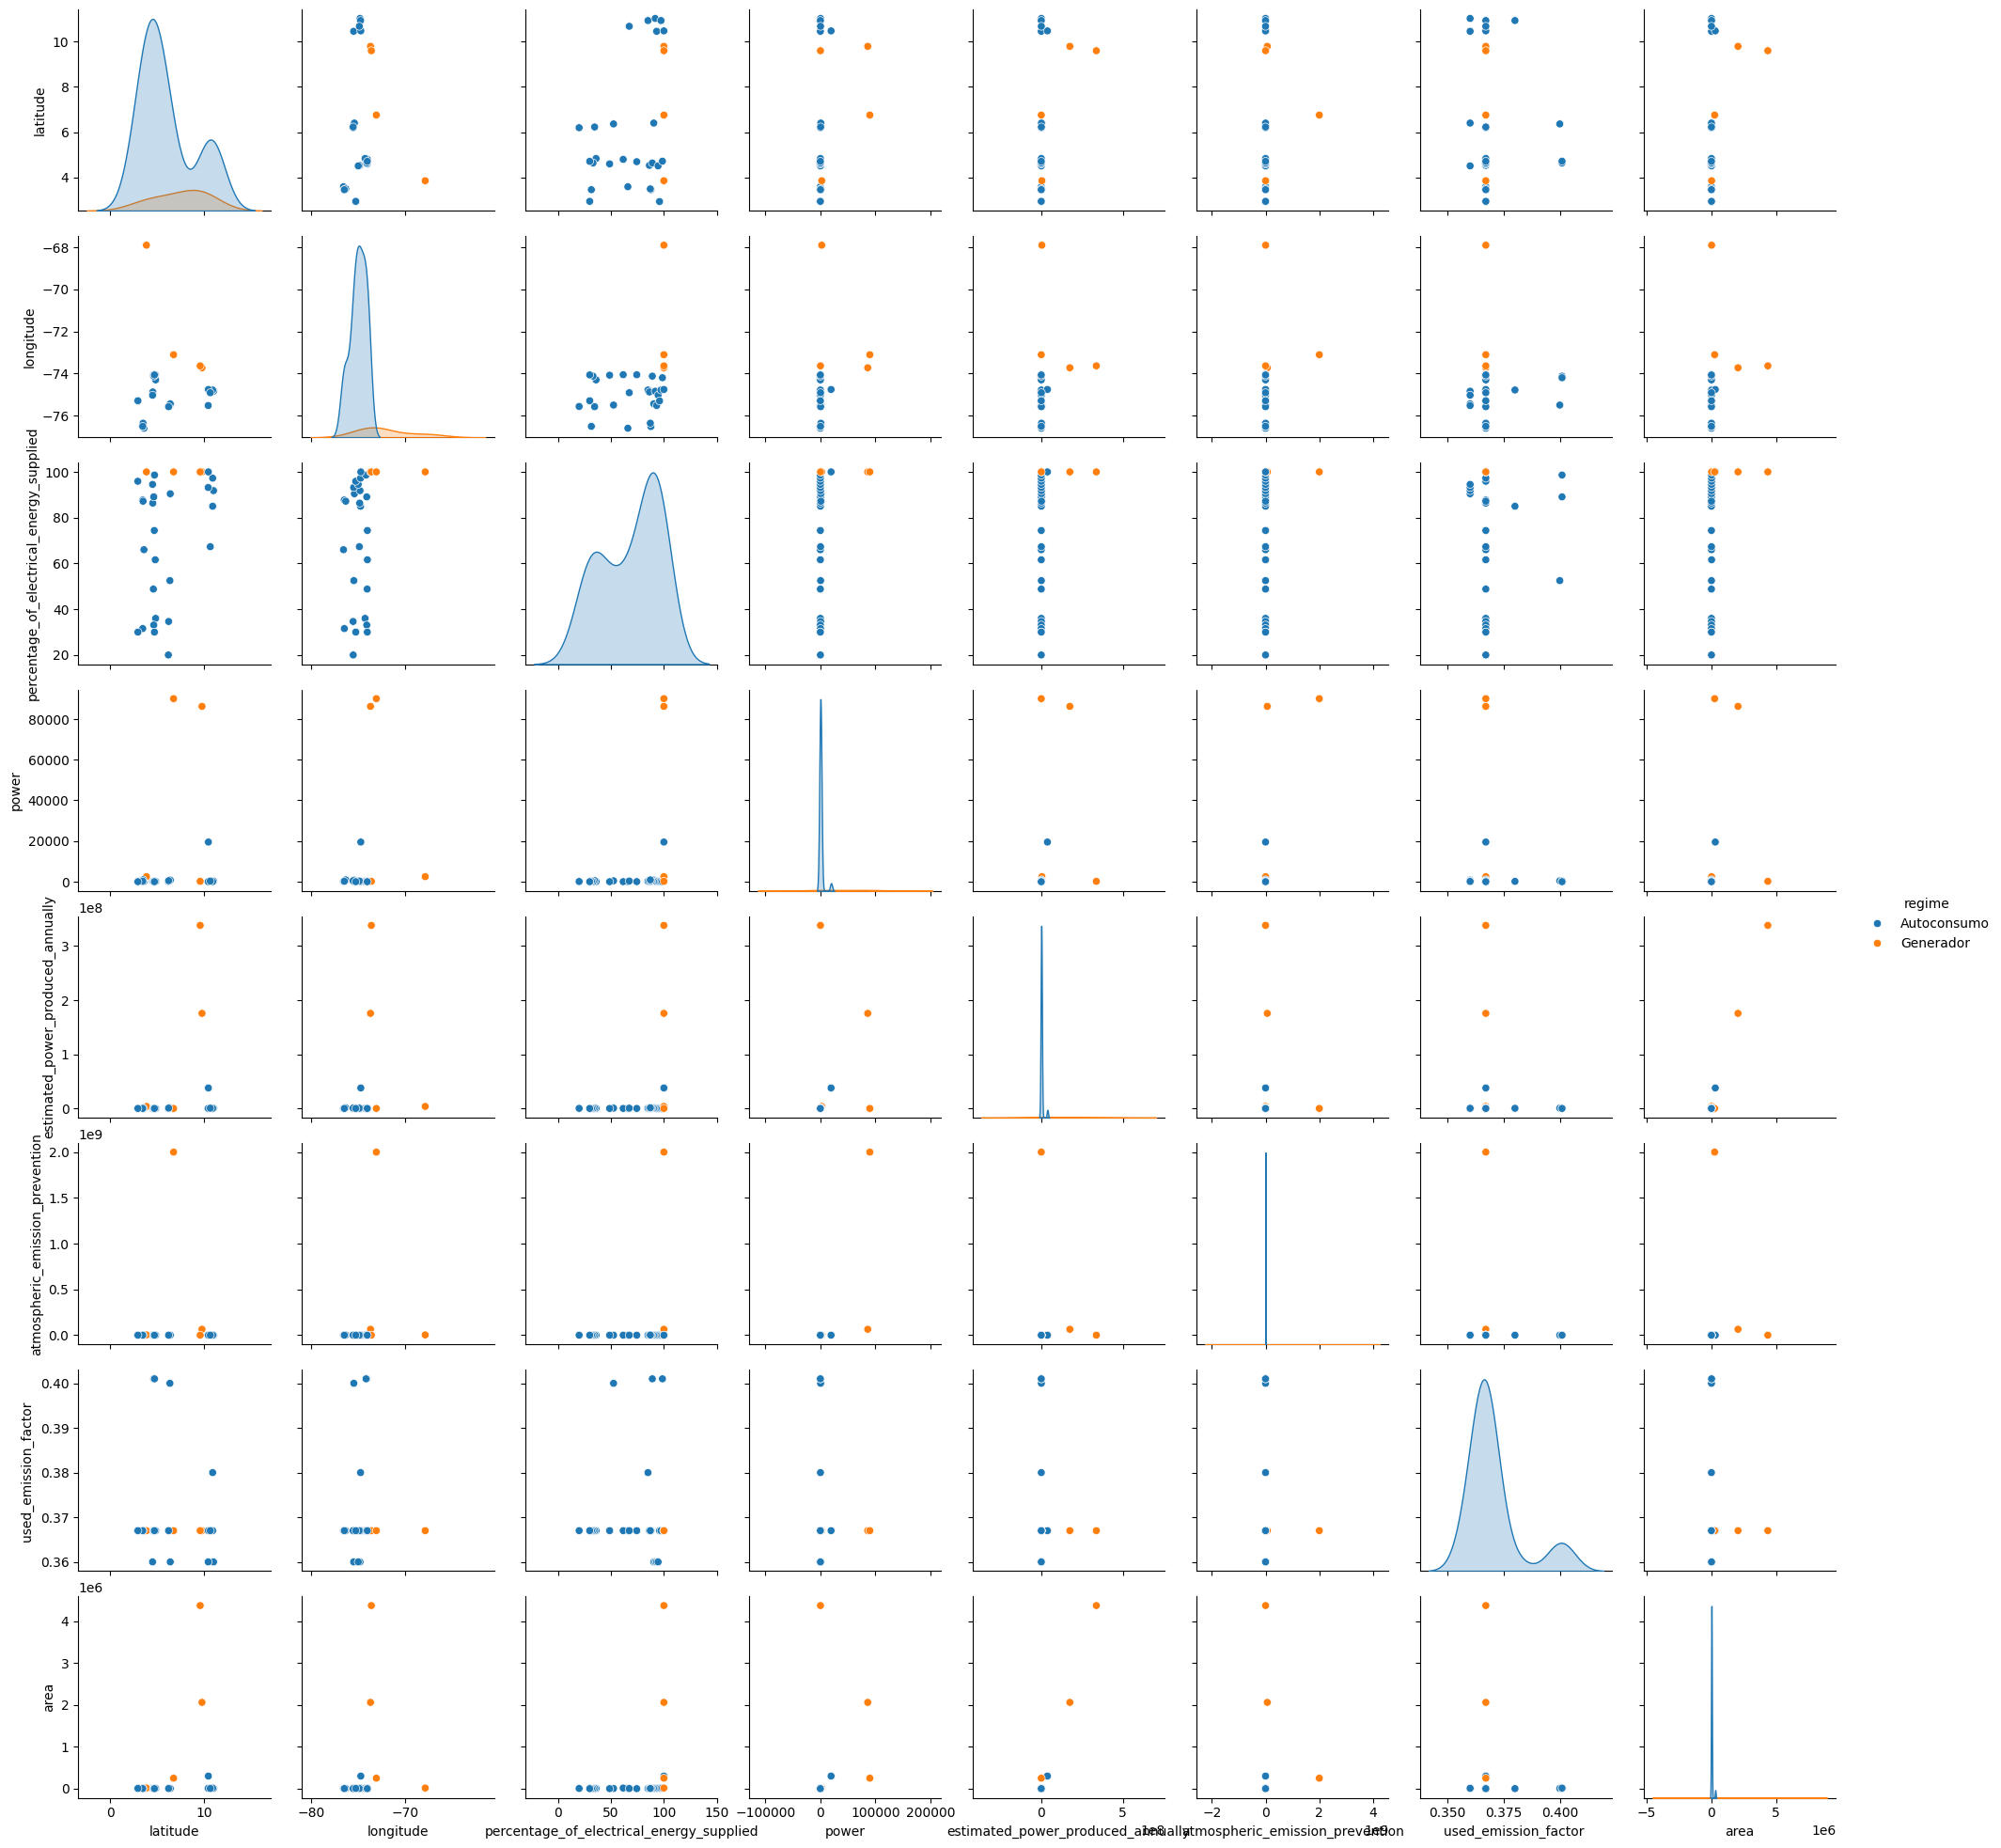

In [22]:
original_project_images = sns.pairplot(projects, hue="regime")

##### Solar panels
At this part, we reed the information saved at solar panels and make a linear interpolation for fill the missing information from prices


In [3]:
solar_panels = pd.read_csv("Data/SolarPanels.csv")
solar_panels['Material'] = solar_panels['Material'].astype('category')
solar_panels_prices = [None for element in range(0,len(solar_panels))]
solar_panels_prices[12] = 348.39
solar_panels_prices[487] = 136.10
solar_panels_prices[300] = 609.75
solar_panels_prices[126] = 432.19
solar_panels_prices[9] = 48.99
solar_panels_prices[517] = 131.73
solar_panels_prices[521] = 457.23
solar_panels_prices[310] = 859.50 
solar_panels_prices[110] = 84
solar_panels_prices[332] = 476.28
solar_panels_prices[258] = 46
solar_panels_prices[253] = 357.52
solar_panels_prices[37] = 32.66
solar_panels_prices[142] = 89.23
solar_panels_prices[434] = 116.47
solar_panels_prices[274] = 272.14
solar_panels_prices[260] = 260
solar_panels_prices[400] = 315.70804
solar_panels['Price'] = solar_panels_prices
solar_panels['Nominal power'] = solar_panels['Impo']  * solar_panels['Vmpo']
solar_panels.describe()
solar_panel_use = solar_panels[
    ["Material",'Module Area [m^2]', "Series Cells", "Parallel C-S", "Isco", "Voco","Impo", "Vmpo", "Price", "Nominal power"]
]

##
for material in solar_panel_use["Material"].unique():
    material_group = solar_panel_use.loc[solar_panel_use["Material"] == material].copy()
    if(material_group["Price"].mean() > 0):
        
        material_group["Price"] = material_group["Price"].interpolate(method="linear")
        material_group["Price"] = material_group["Price"].fillna(material_group["Price"].median())
        solar_panel_use.loc[material_group.index, "Price"] = material_group["Price"]



solar_panel_use = solar_panel_use.dropna()

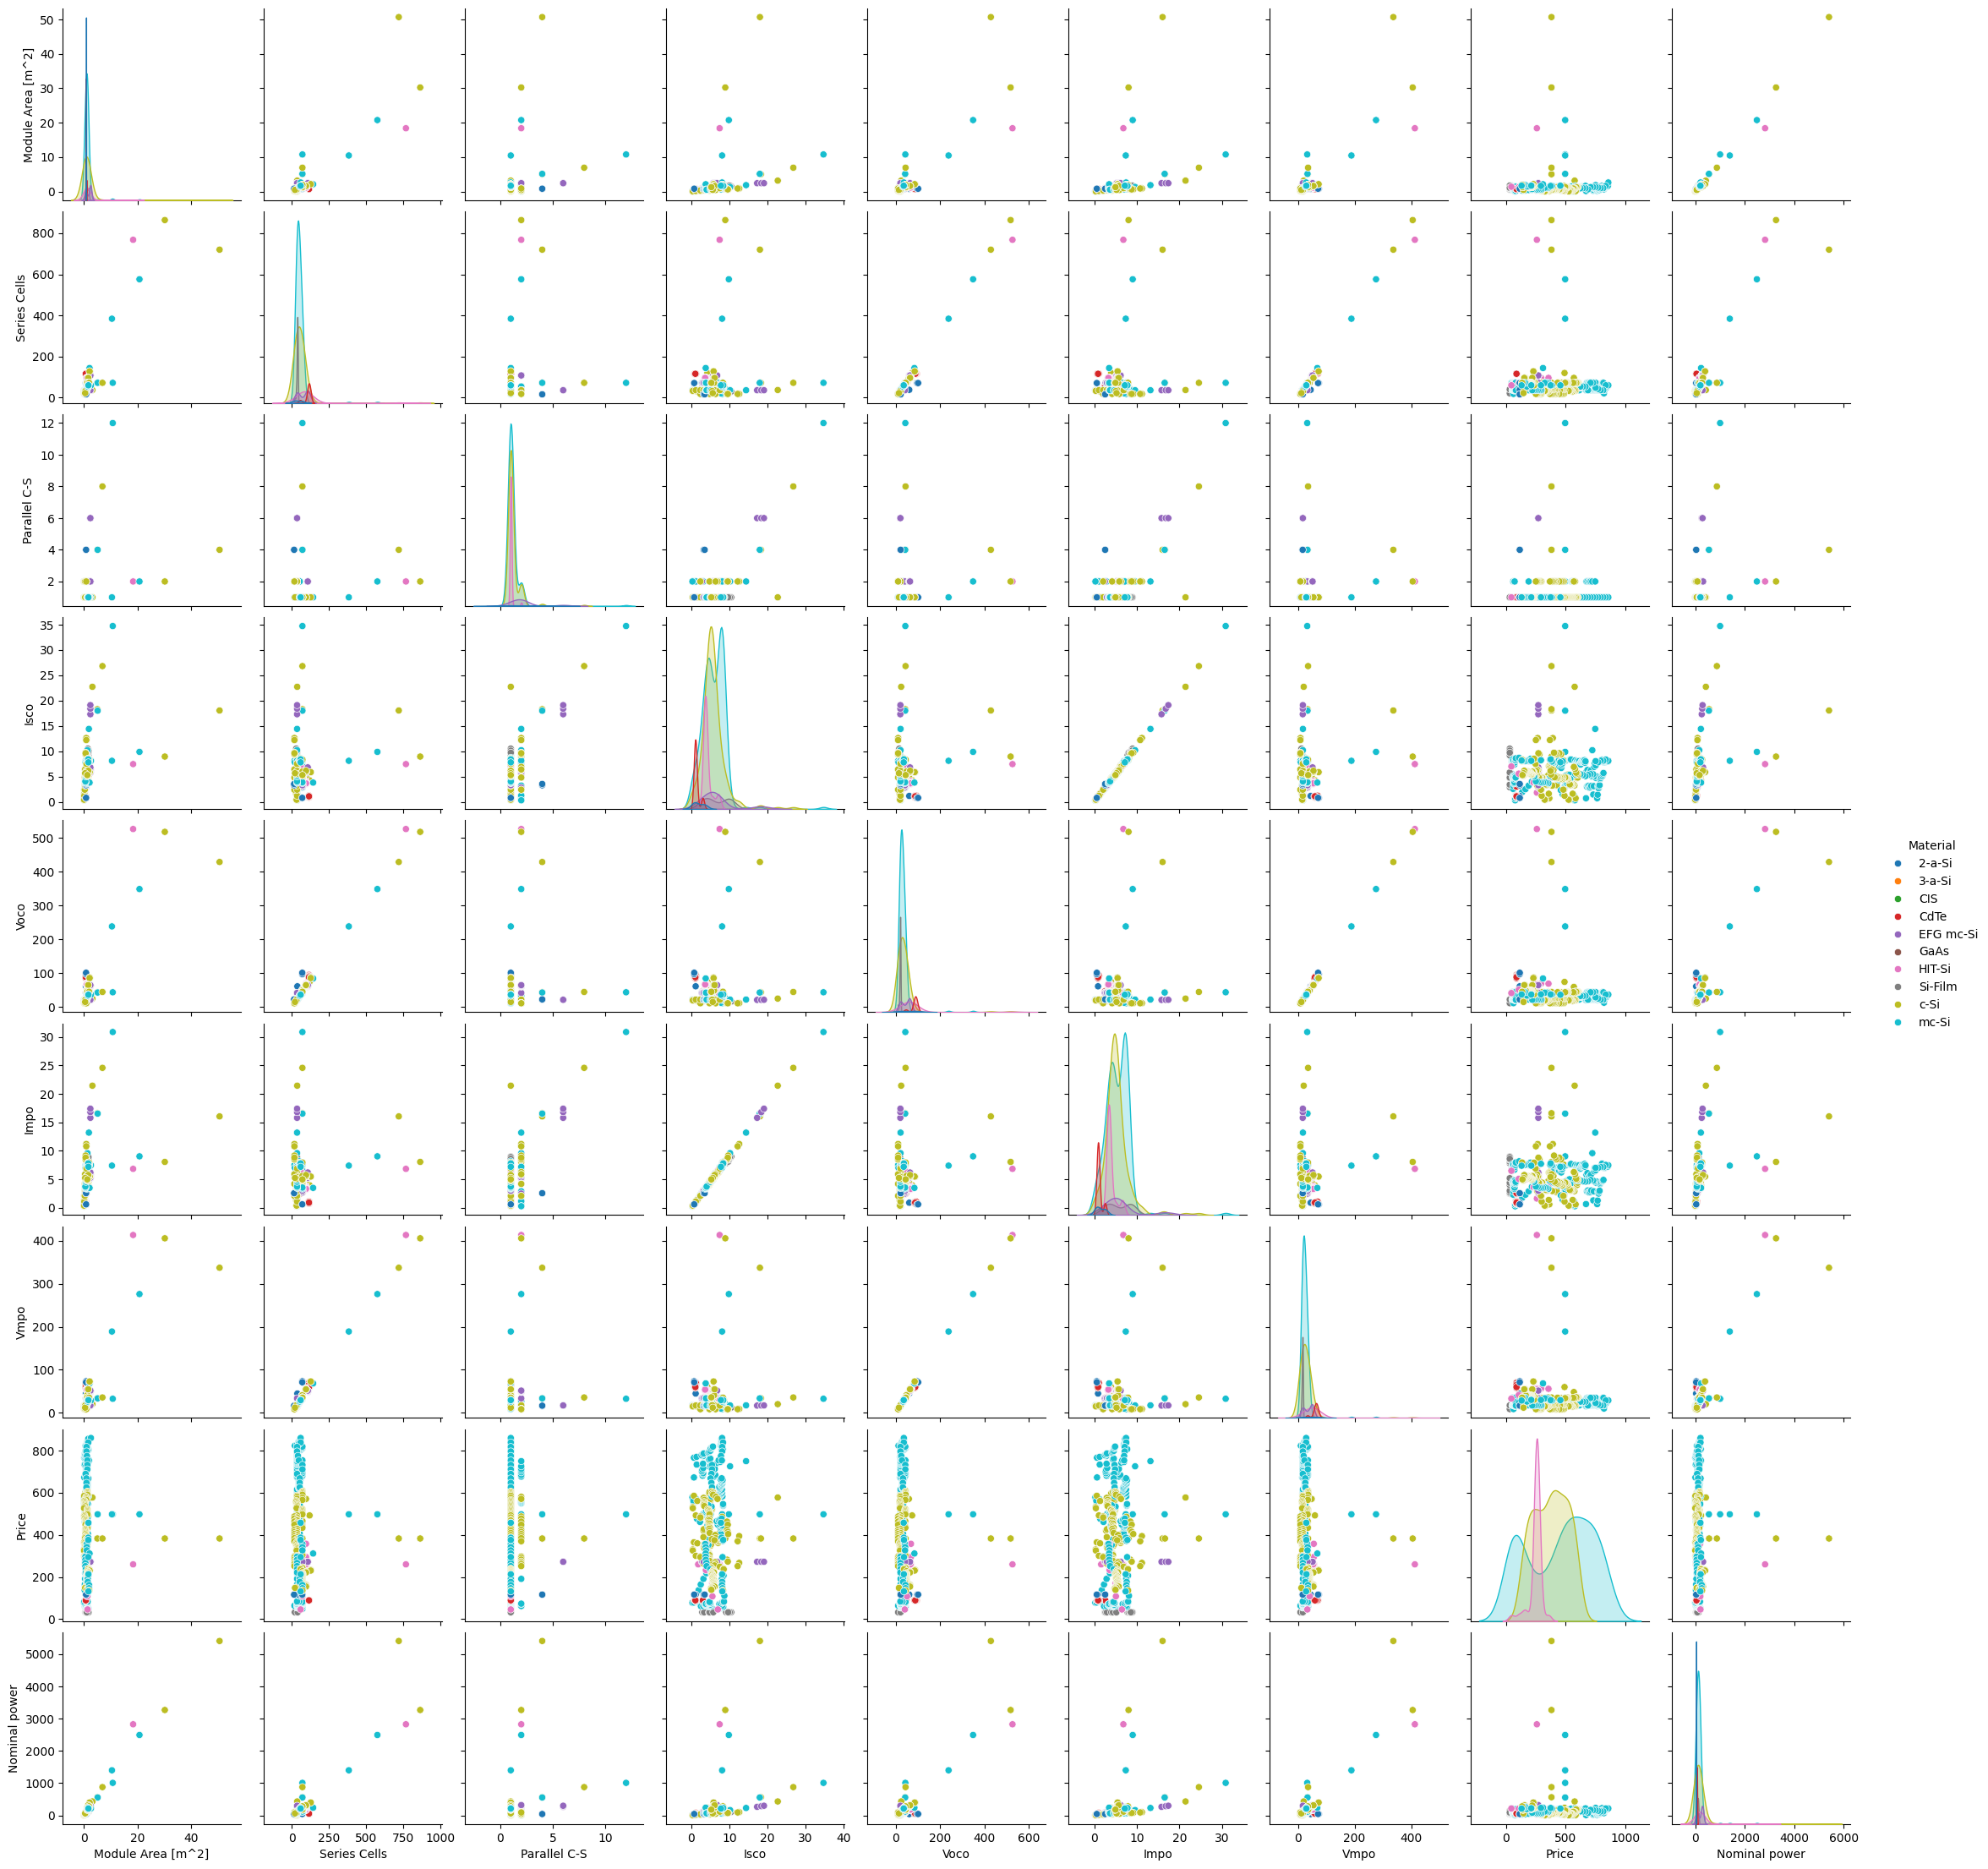

In [4]:
solar_panels_image = sns.pairplot(solar_panel_use, hue="Material")

In [5]:
inverters = pd.read_csv("Data/Inverter.csv")
##Force the prices
inverters_price = [ None for element in range(0,len(inverters))]
inverters_price[336] = 2500
inverters_price[595] =  3000
inverters_price[109] = 2400
inverters_price[17] = 400
inverters["Price"] = inverters_price
inverters["Price"] = inverters["Price"].interpolate(method="linear")
inverters["Price"] = inverters["Price"].fillna(inverters["Price"].median())

##Droping the inverters that don't takes the information
inverters = inverters[ ~inverters['Vdcmax'].isnull() &  ~inverters['Idcmax'].isnull()]
inverters['Vintage'] = pd.to_datetime(inverters['Vintage'], format="%Y")
inverters["Nominal power"] = inverters["Vdcmax"]*inverters["Idcmax"]

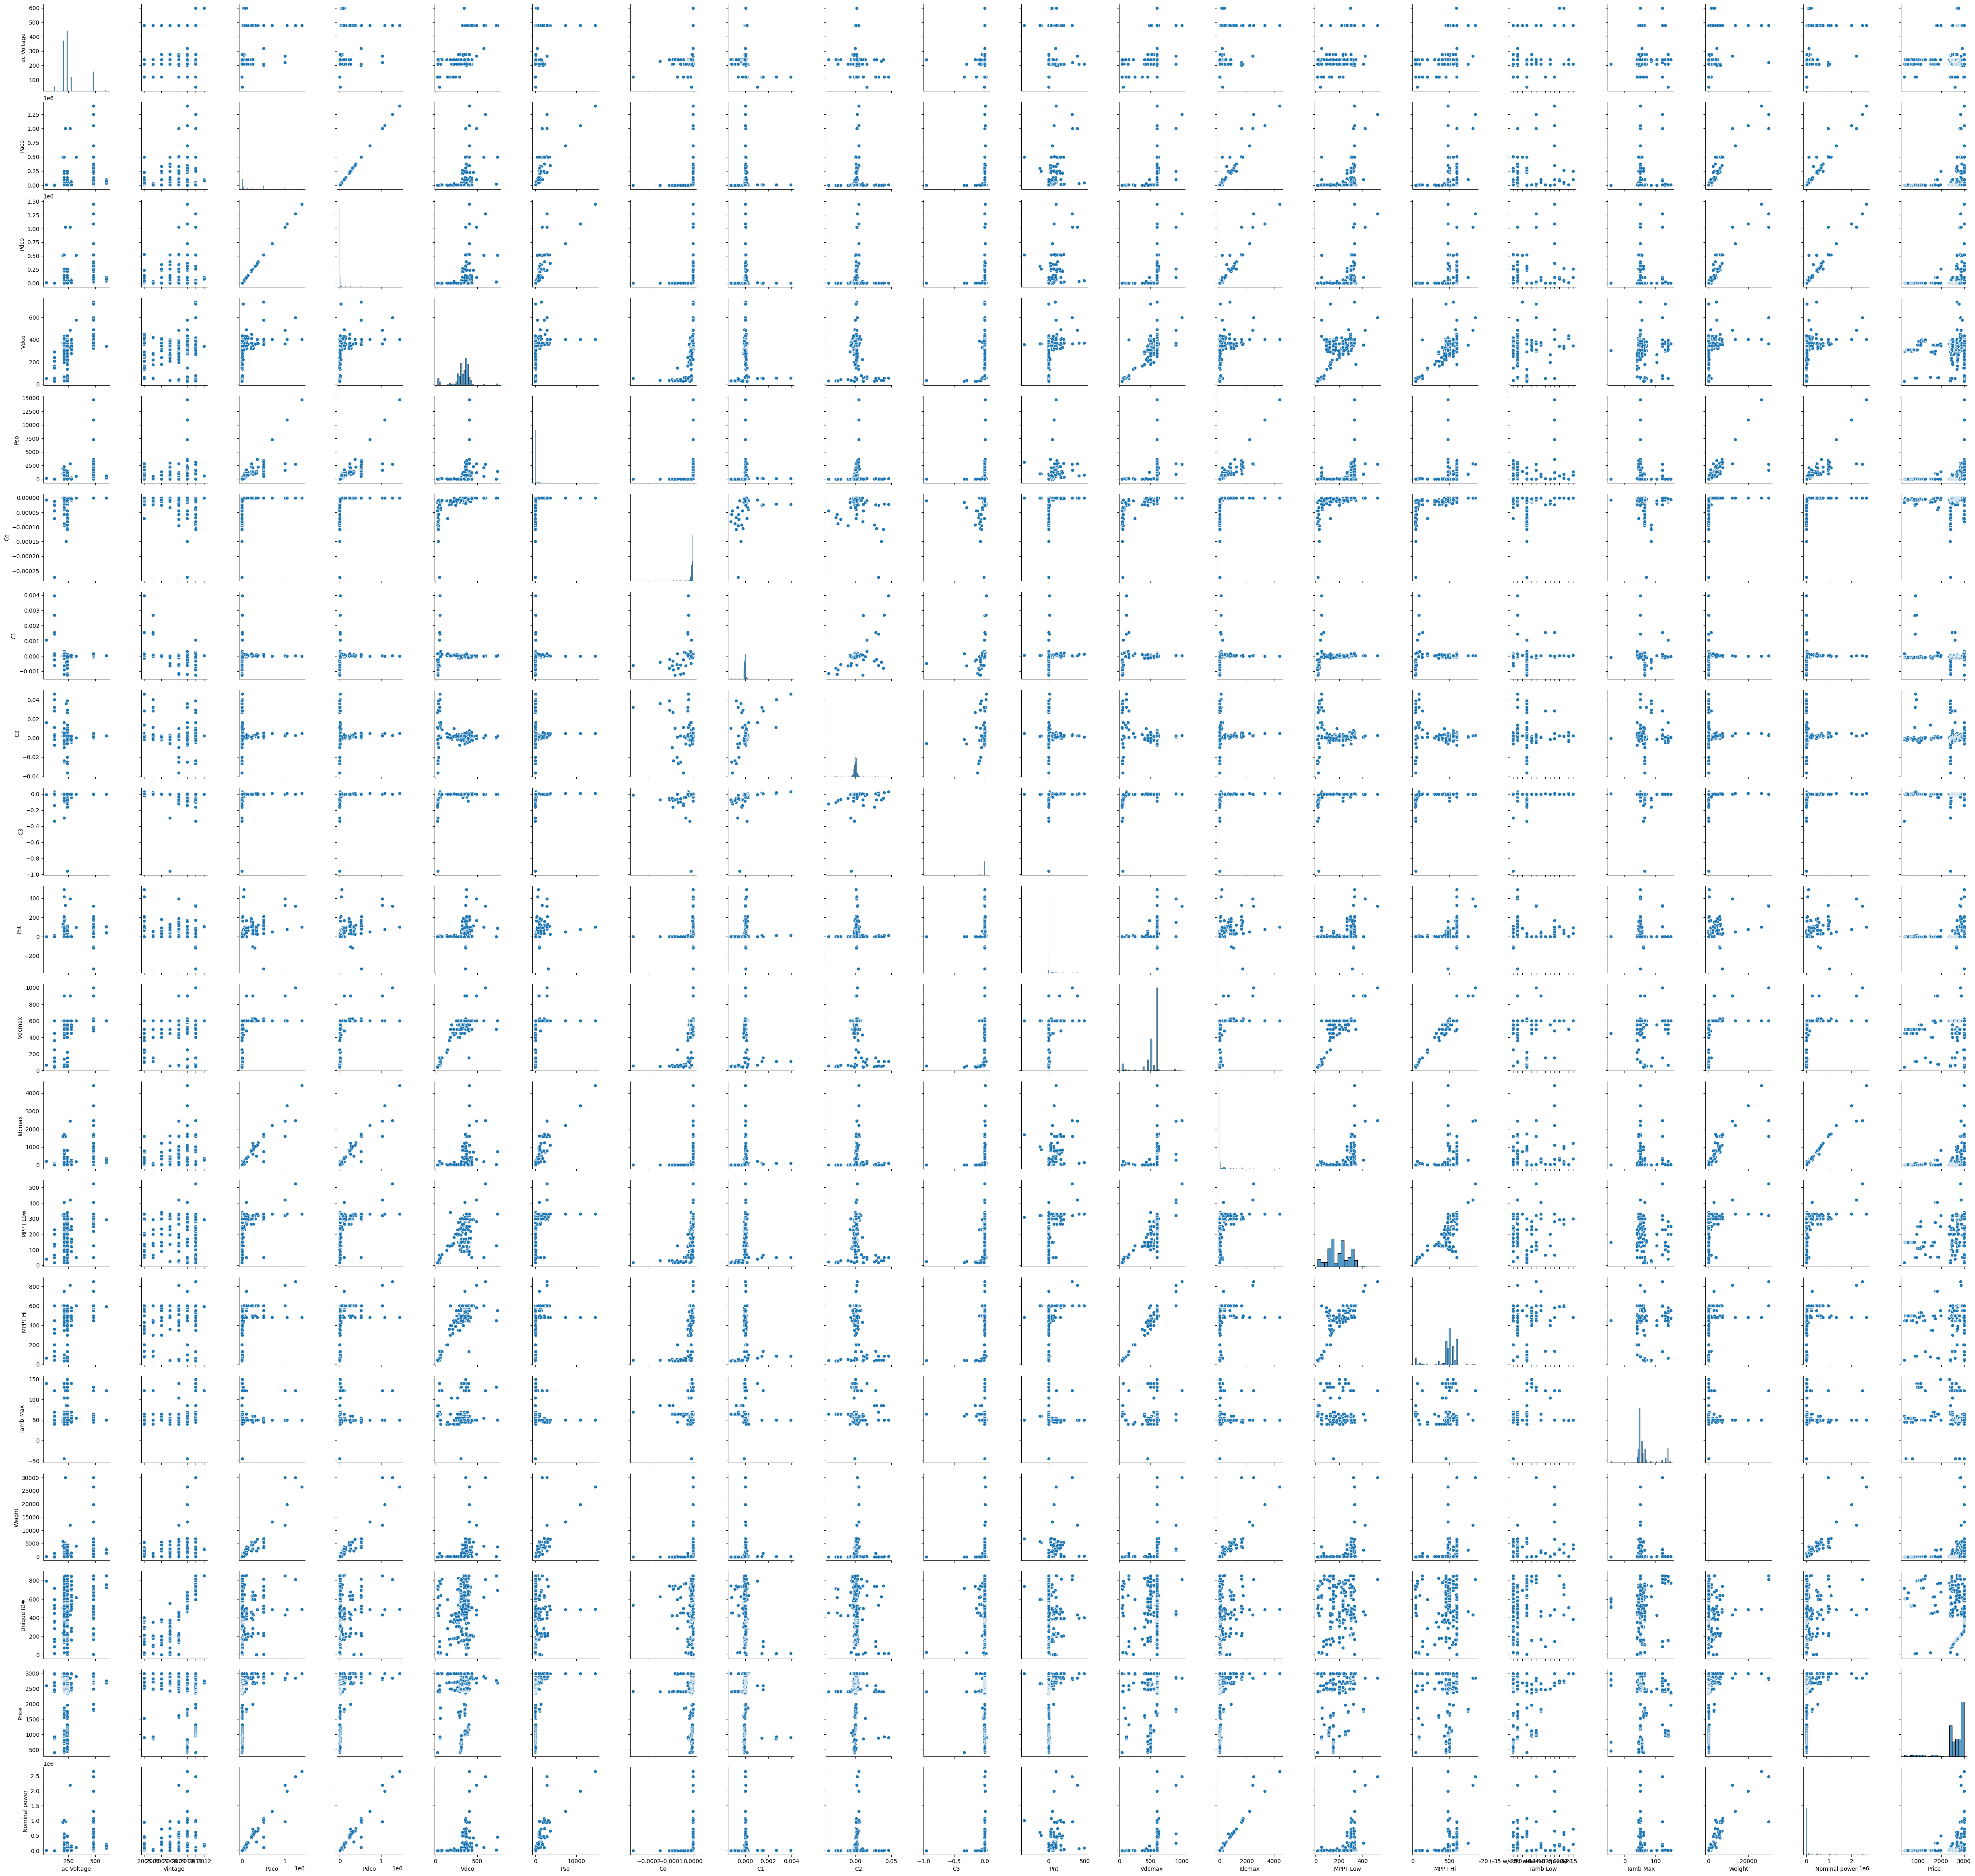

In [6]:
inverter_image = sns.pairplot(inverters, x_vars=['ac Voltage', 'Vintage', 'Paco', 'Pdco',
       'Vdco', 'Pso', 'Co', 'C1', 'C2', 'C3', 'Pnt', 'Vdcmax', 'Idcmax',
       'MPPT-Low', 'MPPT-Hi', 'Tamb Low', 'Tamb Max', 'Weight',
       'Nominal power', "Price"])

### Find more information about the solar projects

#### Find the average solar hours

In [8]:
answer_list = list()   
assistant_tool = AssistantTool.AssistantTool()
solar_information = NASA.SolarInformation()
average_solar_hours_list = []
project_index_list = []
for project_index in range(0,len(projects)):

    project = projects.iloc[project_index]
    parameters = {
        "start":"20230101",
        "end":"20240101",
        "latitude":project['latitude'],
        "longitude":project['longitude'],
        "community":"re",
        "parameters":"ALLSKY_SFC_SW_DWN",
        "format":"json",
        "header":"true",
        "time-standard":"lst"
    }
    average_solar_hours_list.append(solar_information.get_average_solar_hours(parameters))
    project_index_list.append(project_index)
projects['average_solar_hours'] = average_solar_hours_list
projects['id'] = project_index_list

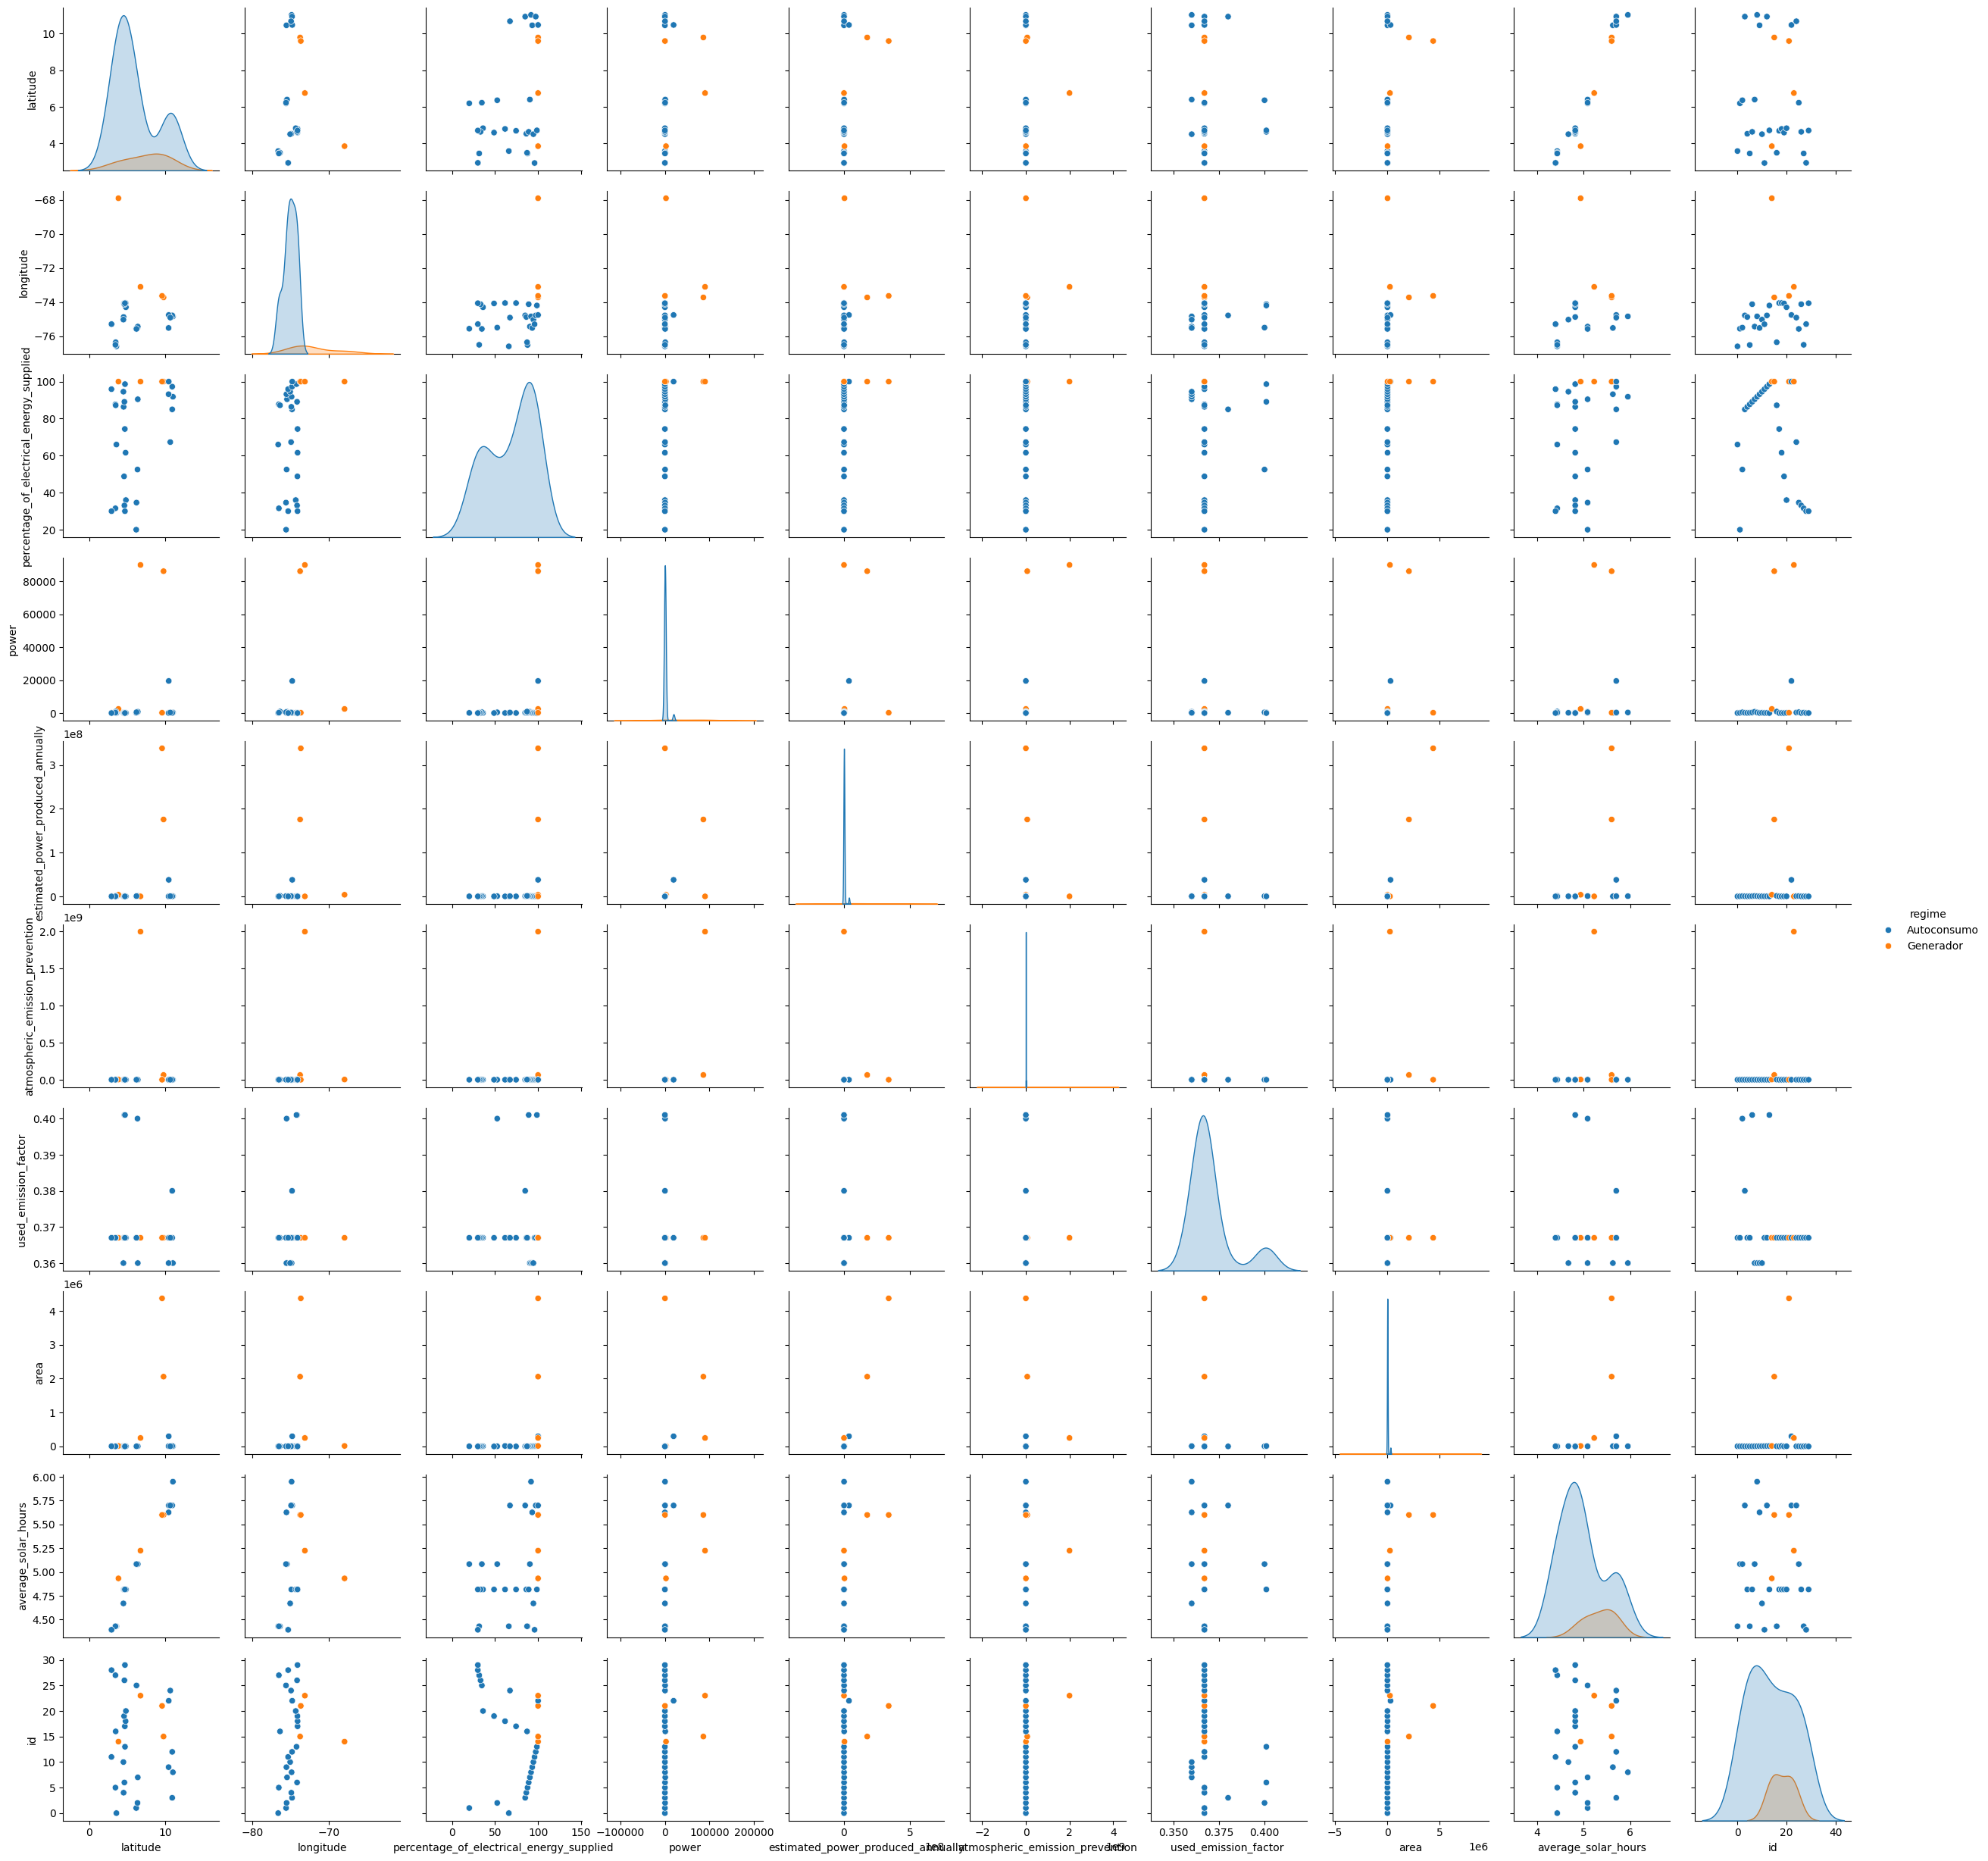

In [9]:
projects_image = sns.pairplot(projects,hue='regime')

In [10]:
answer_list = []
assistant_tool = AssistantTool.AssistantTool()
for index_solar_panel in range(0,150):
    solar_panel = json.loads(solar_panels.iloc[index_solar_panel].to_json())
    solar_panel['id'] = index_solar_panel

    for index_inverter in range(0,150):
        inverter = json.loads(inverters.iloc[index_inverter].to_json())
        inverter['id'] = index_inverter

        for index_project in range(0,len(projects)):
            
            project = json.loads(projects.iloc[index_project].to_json())
            project['id'] = index_project
            answer = assistant_tool.execute(project, solar_panel, inverter)
            if(answer['total_number_of_panels'] != None):
                answer_list.append(answer)

In [11]:
configuration = pd.DataFrame(answer_list)
configuration.head()

,project_id,total_number_of_panels,panels_in_parallel,panels_in_series,number_of_inverters,panel_reference,inverter_reference
0,0,25,12,1,3.393439,0,0
1,1,328,12,1,45.310496,0,0
2,2,475,12,1,65.613853,0,0
3,3,132,12,1,18.145600,0,0
4,4,76,12,1,10.470955,0,0


In [12]:
configuration_v2 = configuration.merge(projects, left_on="project_id", right_on ="id")
configuration_v2 = configuration_v2.drop(columns=["project_id","panel_reference","inverter_reference","id", "latitude","longitude"])
configuration_v2.describe()

,total_number_of_panels,panels_in_parallel,panels_in_series,number_of_inverters,date,percentage_of_electrical_energy_supplied,power,estimated_power_produced_annually,atmospheric_emission_prevention,used_emission_factor,area,average_solar_hours
count,5.612260e+05,561226.000000,561226.000000,561226.000000,561226,561226.000000,561226.000000,5.612260e+05,5.612260e+05,561226.000000,5.612260e+05,561226.000000
mean,1.218148e+05,15.751221,12.100371,3546.841611,2018-08-06 19:05:38.699917568,74.457269,6910.888033,2.251544e+07,5.576321e+07,0.369262,2.808307e+05,5.063440
min,1.000000e+00,1.000000,1.000000,1.003364,2017-12-07 00:00:00,20.000000,3.200000,3.655400e+02,1.598400e+03,0.360000,7.000000e+01,4.392951
25%,3.920000e+02,6.000000,2.000000,5.206724,2018-07-09 00:00:00,52.500000,54.000000,7.575500e+04,1.754300e+04,0.367000,2.500000e+03,4.816694
50%,1.627000e+03,15.000000,4.000000,24.709646,2018-08-15 00:00:00,87.200000,162.000000,2.506300e+05,9.198100e+04,0.367000,4.287940e+03,4.932978
75%,6.360000e+03,24.000000,8.000000,119.745282,2018-10-20 00:00:00,95.909091,505.300000,6.719550e+05,2.201090e+05,0.367000,1.187500e+04,5.599918
max,3.155244e+07,82.000000,2734.000000,403473.412293,2018-11-25 00:00:00,100.000000,90000.000000,3.380152e+08,2.000000e+09,0.401000,4.371700e+06,5.949344
std,7.490654e+05,10.611829,40.449140,23722.542992,NaN,26.109516,21908.342593,7.326342e+07,3.207205e+08,0.010143,9.288537e+05,0.470130


### Training the model

In [13]:
#sns.pairplot(configuration_v2, hue="regime")

### Solar panels information

In [14]:
solar_panels

,Model,Vintage,Module Area [m^2],Material,Series Cells,Parallel C-S,Isco,Voco,Impo,Vmpo,...,b,C4,C5,Ixo,Ixxo,C6,C7,Data source,Price,Nominal power
0,12-PW1000(95W)-Array,2001,10.780,mc-Si,72,12,34.720,43.320,30.860,32.690,...,-0.08500,0.97000,0.030000,33.8000,21.8000,1.1090,-0.1090,1.0,NaN,1008.813400
1,16-SanyoH552BA2-Array,2004,18.400,HIT-Si,768,2,7.453,525.980,6.840,413.140,...,-0.10100,0.99920,0.000800,7.3900,4.9700,1.1020,-0.1020,1.0,NaN,2825.877600
2,32-BP380-Array,2004,20.770,mc-Si,576,2,9.869,348.500,9.039,275.900,...,-0.09600,0.99610,0.003900,9.6500,6.4900,1.1549,-0.1549,1.0,NaN,2493.860100
3,48-BP270 (70W)-Array,2001,30.240,c-Si,864,2,8.940,517.600,8.060,405.500,...,-0.07500,0.97890,0.021100,8.5200,5.4200,1.1468,-0.1468,1.0,NaN,3268.330000
4,8 Sharp 167U1F Array,2007,10.480,mc-Si,384,1,8.106,238.054,7.407,188.919,...,-0.09600,0.98689,0.013113,7.9150,5.1500,1.0872,-0.0872,1.0,NaN,1399.323033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,Yingli Solar YL220 Module,2008,1.700,mc-Si,60,1,8.163,36.871,7.388,28.633,...,-0.10120,0.98920,0.010800,8.0491,5.1339,1.1335,-0.1335,1.0,131.73,211.540604
518,Yingli Solar YL220 Module,2008 (E),1.700,mc-Si,60,1,8.100,36.600,7.400,30.000,...,-0.10120,0.98920,0.010800,8.2900,5.1339,1.1335,-0.1335,NaN,NaN,222.000000
519,Yingli Solar YL230-29b Module,2009,1.634,mc-Si,60,1,8.222,37.280,7.727,29.886,...,-0.09143,0.99500,0.005000,8.1509,5.5099,1.1325,-0.1325,1.0,NaN,230.929122
520,Yingli Solar YL230-29b Module,2009 (E),1.634,mc-Si,60,1,8.400,37.000,7.800,29.500,...,-0.09143,0.99500,0.005000,8.3100,5.5700,1.1325,-0.1325,NaN,NaN,230.100000


In [15]:
solar_panels.describe()

,Module Area [m^2],Series Cells,Parallel C-S,Isco,Voco,Impo,Vmpo,aIsc,aImp,C0,...,b,C4,C5,Ixo,Ixxo,C6,C7,Data source,Price,Nominal power
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,...,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,103.000000,18.000000,522.000000
mean,1.286334,58.208812,1.229885,5.399195,37.776689,4.909934,29.858196,0.000521,-0.000080,1.000763,...,-0.074033,0.992577,0.007425,5.305397,3.493573,1.118648,-0.118648,1.058252,281.882669,156.023614
std,2.898243,66.922797,0.801167,3.335621,42.370972,3.040168,33.311955,0.000235,0.000356,0.031420,...,0.011894,0.016089,0.016089,3.286419,2.161075,0.028140,0.028140,0.415986,225.382571,330.001994
min,0.058000,5.000000,1.000000,0.300000,10.700000,0.270000,7.500000,-0.000060,-0.000860,0.924000,...,-0.130400,0.963000,-0.059000,0.295000,0.196000,1.029700,-0.202000,1.000000,32.660000,2.673000
25%,0.632000,36.000000,1.000000,3.622500,21.500000,3.267500,16.900000,0.000390,-0.000210,0.988000,...,-0.075000,0.985000,0.005500,3.547500,2.335000,1.105000,-0.133000,1.000000,96.040000,64.085140
50%,1.008000,41.000000,1.000000,4.968500,24.450000,4.550000,18.950000,0.000540,-0.000142,0.995500,...,-0.075000,0.988500,0.012000,4.790000,3.235000,1.118300,-0.118300,1.000000,266.070000,110.565000
75%,1.310000,72.000000,1.000000,7.405250,43.500000,6.677500,34.750000,0.000650,-0.000006,1.006000,...,-0.072100,0.994500,0.015000,7.291250,4.787500,1.133000,-0.105000,1.000000,413.522500,180.049250
max,50.700000,864.000000,12.000000,34.720000,525.980000,30.860000,413.140000,0.001200,0.001470,1.121000,...,-0.045500,1.059000,0.037000,33.800000,21.800000,1.202000,-0.029700,4.000000,859.500000,5409.492000


### Inverters information

In [16]:
inverters

,Manufacturer,ID,Source,ac Voltage,Vintage,Paco,Pdco,Vdco,Pso,Co,...,Vdcmax,Idcmax,MPPT-Low,MPPT-Hi,Tamb Low,Tamb Max,Weight,Unique ID#,Price,Nominal power
0,"Ablerex Electronics Co., Ltd.",ES 2200-US-240 (240 Vac),CEC,240,2011-01-01,2110.0,2191.825129,399.207333,30.843703,-4.124599e-06,...,500.0,14.6,150.0,450.0,-25,50.0,51.0,645,2688.223938,7300.0
1,"Ablerex Electronics Co., Ltd.",ES 3300-US-240 (240 Vac),CEC,240,2011-01-01,3180.0,3313.675805,389.513254,31.265046,-6.000687e-06,...,500.0,22.0,150.0,450.0,-25,50.0,51.0,646,2688.223938,11000.0
2,"Ablerex Electronics Co., Ltd.",ES 4200-US-240 (240 Vac),CEC,240,2011-01-01,4160.0,4342.409314,388.562050,31.601704,-4.405825e-06,...,500.0,28.0,150.0,450.0,-25,50.0,62.0,675,2688.223938,14000.0
3,"Ablerex Electronics Co., Ltd.",ES 5000-US-240 (240 Vac),CEC,240,2011-01-01,5240.0,5495.829926,386.082539,32.450808,-4.704421e-06,...,500.0,35.3,150.0,450.0,-25,50.0,62.0,676,2688.223938,17650.0
4,Advanced Energy,3159000-104,CEC,480,2007-01-01,333000.0,343251.100373,370.088452,1427.745504,-5.768095e-08,...,600.0,500.0,330.0,600.0,-20,50.0,2175.0,1,2688.223938,300000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,Zigor,Sunzet 2 TL-US,CEC,240,2011-01-01,2110.0,2191.825129,399.207333,30.843703,-4.124599e-06,...,500.0,14.6,150.0,450.0,-25,50.0,51.0,649,3000.000000,7300.0
847,Zigor,Sunzet 3 TL-US,CEC,240,2011-01-01,3180.0,3313.675805,389.513254,31.265046,-6.000687e-06,...,500.0,22.0,150.0,450.0,-25,50.0,51.0,650,3000.000000,11000.0
848,Zigor,Sunzet 4 TL-US,CEC,240,2011-01-01,4160.0,4342.409314,388.562050,31.601704,-4.405825e-06,...,500.0,28.0,150.0,450.0,-25,50.0,62.0,687,3000.000000,14000.0
849,Zigor,Sunzet 5 TL-US,CEC,240,2011-01-01,5240.0,5495.829926,386.082539,32.450808,-4.704421e-06,...,500.0,35.3,150.0,450.0,-25,50.0,62.0,688,3000.000000,17650.0


In [17]:
inverters.describe()

,ac Voltage,Vintage,Paco,Pdco,Vdco,Pso,Co,C1,C2,C3,Pnt,Vdcmax,Idcmax,MPPT-Low,MPPT-Hi,Tamb Max,Weight,Unique ID#,Price,Nominal power
count,550.000000,547,5.500000e+02,5.500000e+02,550.000000,550.000000,5.500000e+02,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,536.000000,536.000000,537.000000,536.000000,550.000000,550.000000,5.500000e+02
mean,261.992727,2009-06-13 22:09:25.996343808,5.380440e+04,5.596207e+04,321.399495,323.515404,-8.596873e-06,-0.000017,0.000542,-0.007590,19.922566,525.244182,166.357909,197.902985,477.611940,65.147114,943.457672,523.700000,2577.862820,1.021231e+05
min,48.000000,2005-01-01 00:00:00,1.750000e+02,1.847213e+02,27.664967,0.739248,-2.715962e-04,-0.001242,-0.036783,-0.956670,-335.800000,42.000000,6.300000,16.000000,35.000000,-45.000000,2.200000,1.000000,400.000000,3.483900e+02
25%,208.000000,2009-01-01 00:00:00,2.985000e+03,3.111820e+03,293.084244,21.840106,-7.654707e-06,-0.000065,-0.000878,-0.002868,0.200000,500.000000,15.000000,150.000000,450.000000,50.000000,44.100000,382.250000,2463.546256,7.500000e+03
50%,240.000000,2010-01-01 00:00:00,4.393000e+03,4.654540e+03,341.851583,31.281025,-4.206565e-06,-0.000022,0.000335,-0.000668,0.500000,600.000000,22.750000,200.000000,500.000000,50.000000,62.000000,549.500000,2688.223938,1.200000e+04
75%,240.000000,2011-01-01 00:00:00,2.254500e+04,2.335425e+04,373.542976,125.461040,-8.579942e-07,0.000027,0.001727,0.000145,3.857500,600.000000,99.000000,265.000000,550.000000,65.000000,162.000000,707.750000,3000.000000,3.631500e+04
max,600.000000,2012-01-01 00:00:00,1.400000e+06,1.454615e+06,737.514286,14618.815727,1.897993e-08,0.003955,0.046323,0.028709,489.000000,1000.000000,4412.000000,525.000000,850.000000,149.000000,30000.000000,854.000000,3000.000000,2.647200e+06
std,93.834059,NaN,1.473257e+05,1.523719e+05,100.272479,990.510661,2.011094e-05,0.000317,0.006451,0.048220,55.151711,144.827762,411.893807,86.184468,136.388322,33.188386,2746.232834,219.600911,554.286350,2.710671e+05
